In [ ]:
!nvidia-smi

Tue Apr 15 17:52:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import numpy as np
from glob import glob
from google.colab import drive

drive.mount('/content/drive')

# Image dimensions
width, height = 500, 500
train_images = []
train_path = "/content/drive/MyDrive/CNN_Dataset/Train"

train_files = [os.path.join(train_path, file) for file in os.listdir(train_path) if file.endswith('.jpg')]
for path in train_files:
    img = cv2.imread(path)
    if img is not None:
        img = cv2.GaussianBlur(img, (5, 5), 0)
        train_images.append(cv2.resize(img, (width, height)))
    else:
        print(f"Warning: Image not found or could not be read at path: {path}")

test_images = []
test_path = "/content/drive/MyDrive/CNN_Dataset/Test"

test_files = [os.path.join(test_path, file) for file in os.listdir(test_path) if file.endswith('.jpg')]
for path in test_files:
    img = cv2.imread(path)
    if img is not None:
        img = cv2.GaussianBlur(img, (5, 5), 0)
        test_images.append(cv2.resize(img, (width, height)))
    else:
        print(f"Warning: Image not found or could not be read at path: {path}")

IMAGE_SIZE = [200, 200]

mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers
for layer in mobilenet.layers:
    layer.trainable = False

# Get class folders
folders = glob('/content/drive/MyDrive/CNN_Dataset/Train/*')

# Add custom layers on top
x = Flatten()(mobilenet.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)

# Create model
model = Model(inputs=mobilenet.input, outputs=prediction)

# Compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# ImageDataGenerator with MobileNet preprocess function
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Define class list
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'ExcuseMe',
           'F', 'Food', 'G', 'H', 'Hello', 'Help', 'House', 'I', 'I Love You', 'Internet',
           'J', 'K', 'L', 'M', 'N', 'No', 'O', 'P', 'Please', 'Q', 'R', 'S', 'T', 'ThankYou',
           'U', 'V', 'W', 'X', 'Y', 'Yes', 'Z']

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=8,
                                                 class_mode='categorical',
                                                 classes=classes)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=IMAGE_SIZE,
                                            batch_size=8,
                                            class_mode='categorical',
                                            classes=classes)

# Train the model
import time
start_time = time.time()

try:
    r = model.fit(
        training_set,
        validation_data=test_set,
        epochs=15,
        steps_per_epoch=len(training_set) // training_set.batch_size,
        validation_steps=len(test_set) // test_set.batch_size
    )
except Exception as e:
    print("An error occurred:", str(e))

end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

model.save('/content/drive/MyDrive/MobileNet_CNN_Model.keras')


Mounted at /content/drive


<ipython-input-2-d32b2bd3cd1f>:42: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 4314 images belonging to 46 classes.
Found 222 images belonging to 46 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5485 - loss: 2.0290 - val_accuracy: 1.0000 - val_loss: 0.0477
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9469 - loss: 0.2385 - val_accuracy: 1.0000 - val_loss: 0.0361
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9899 - loss: 0.0575 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9826 - loss: 0.0552 - val_accuracy: 1.0000 - val_loss: 9.1393e-04
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9984 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 5.5647e-04
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9980 - loss: 0.0309 - val_accuracy: 0.9583 - val_loss: 0.0859
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 63s 952ms/step - accuracy: 0.9916 - loss: 0.0275 - val_accuracy: 0.9583 - val_loss: 0.0884
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 878ms/step - accuracy: 0.9962 - loss: 0.0307 - val_accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.9583 - val_loss: 0.1411
Epoch 10/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9998 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 11/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 12/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 13/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 617ms/step - accuracy: 0.9989 - loss: 0.0075 - val_accuracy: 0.9583 - val_loss: 0.0823
Epoch 14/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.9946 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 6.8029e-04
Epoch 15/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 614ms/step - accuracy: 0.9998 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 6.8313e-04
Total training time: 1156.46 seconds


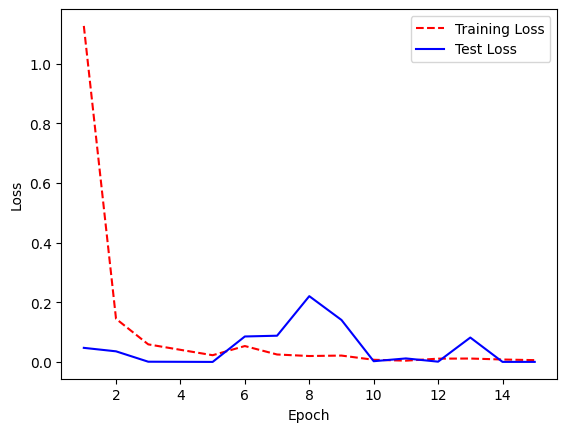

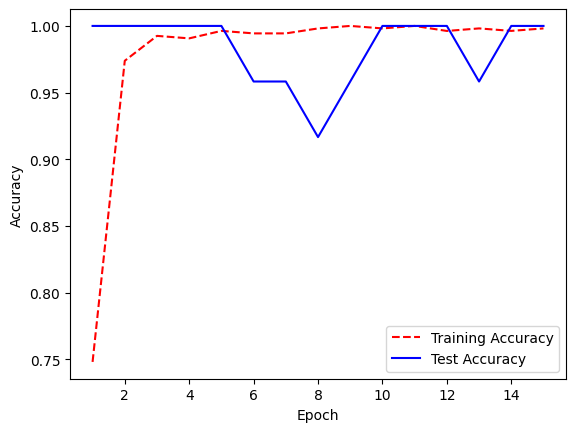

In [3]:
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = r.history['loss']
test_loss = r.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get training and test accuracy
training_accuracy = r.history['accuracy']
test_accuracy = r.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy -
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

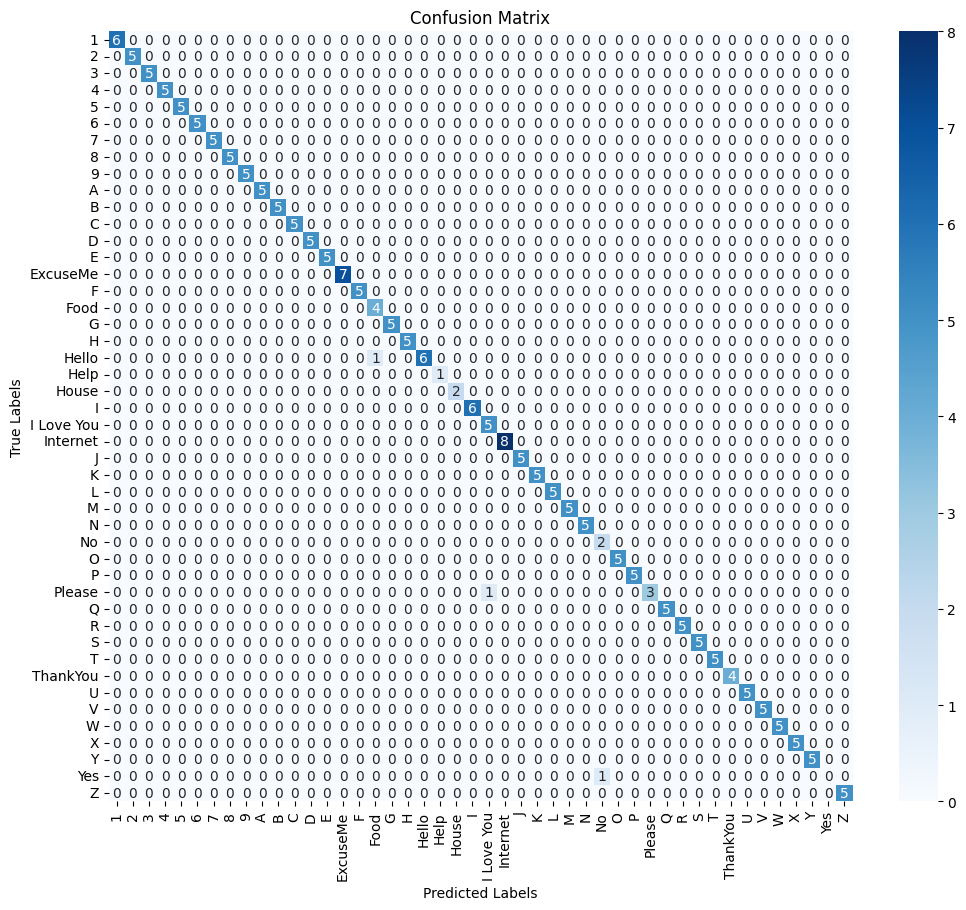

Precision: 0.9851
Recall: 0.9865
F1 Score: 0.9846
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
           A       1.00      1.00      1.00         5
           B       1.00      1.00      1.00         5
           C       1.00      1.00      1.00         5
           D       1.00      1.00      1.00         5
           E       1.00      1.00      1.00         5
    ExcuseMe       1.00      1.00      1.00         7
           F       1.00      1.00      1.00         5
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow import keras

# Load the trained model
my_model = keras.models.load_model('/content/drive/MyDrive/MobileNet_CNN_Model.keras')

# Get the ground truth labels and predictions
true_labels = []
pred_labels = []

# Get class labels from the training set
class_labels = list(training_set.class_indices.keys())

def get_predictions(dataset):
    true_labels = []
    pred_labels = []
    for i in range(len(dataset)):
        images, labels = dataset[i]  # Get batch
        preds = my_model.predict(images)  # Predict
        true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot to integer labels
        pred_labels.extend(np.argmax(preds, axis=1))  # Get predicted class
    return np.array(true_labels), np.array(pred_labels)

# Get predictions for test dataset
true_labels, pred_labels = get_predictions(test_set)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


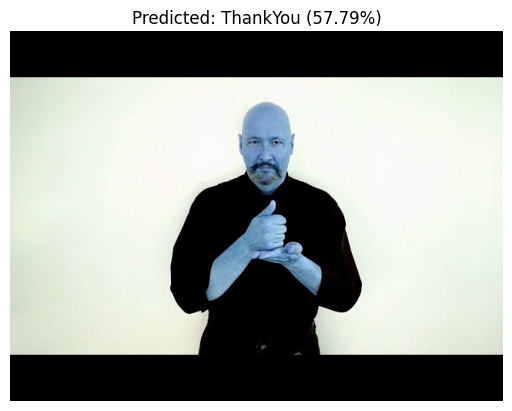

In [1]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet

# Load the trained CNN model
model = keras.models.load_model('/content/drive/MyDrive/MobileNet_CNN_Model.keras')

classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'ExcuseMe',
           'F', 'Food', 'G', 'H', 'Hello', 'Help', 'House', 'I', 'I Love You', 'Internet', 'J',
           'K', 'L', 'M', 'N', 'No', 'O', 'P', 'Please', 'Q', 'R', 'S', 'T', 'ThankYou', 'U',
           'V', 'W', 'X', 'Y', 'Yes', 'Z']
# Load and preprocess the image
image_path = "/content/drive/MyDrive/help.jpg"  # Update with your image path
image = cv2.imread(image_path)  # Read image
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (if using OpenCV)
img = cv2.resize(img, (200, 200))  # Resize to match model input size
img = img / 255.0  # Normalize pixel values (0-1)
img = np.expand_dims(img, axis=0)  # Add batch dimension

predictions = model.predict(img)
predicted_index = np.argmax(predictions, axis=1)[0]  # Get class index
predicted_class = classes[predicted_index]  # Map index to class label
confidence = np.max(predictions) * 100  # Get confidence percentage

# Display results
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.show()


In [1]:
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
# Import for displaying images in Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64encode

# Load the CNN model
model = keras.models.load_model('/content/drive/MyDrive/MobileNet_CNN_Model.keras')
# Define class labels (same order as training)
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'ExcuseMe',
           'F', 'Food', 'G', 'H', 'Hello', 'Help', 'House', 'I', 'I Love You', 'Internet',
           'J', 'K', 'L', 'M', 'N', 'No', 'O', 'P', 'Please', 'Q', 'R', 'S', 'T', 'ThankYou',
           'U', 'V', 'W', 'X', 'Y', 'Yes', 'Z']

# Set image size expected by the model
IMG_SIZE = (200, 200)

# Start webcam
cap = cv2.VideoCapture(1)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

cap.set(3, 640)  # width
cap.set(4, 640)  # height

print("Starting real-time classification... Press 'q' to quit.")

# Function to display the frame in Colab
def display_frame(frame):
  # Convert the frame to JPEG
  ret, jpeg = cv2.imencode('.jpg', frame)
  jpeg_bytes = jpeg.tobytes()

  # Display the frame using JavaScript
  display(Javascript('''
    var imageData = new ImageData(%d, %d);
    var data = imageData.data;
    var bytes = new Uint8Array(atob('%s'));
    for (var i = 0; i < bytes.length; i++) {
      data[i] = bytes[i];
    }
    var canvas = document.createElement('canvas');
    canvas.width = %d;
    canvas.height = %d;
    var ctx = canvas.getContext('2d');
    ctx.putImageData(imageData, 0, 0);
    document.body.appendChild(canvas);
  ''' % (frame.shape[1], frame.shape[0], b64encode(jpeg_bytes).decode(), frame.shape[1], frame.shape[0])))

try:
  while True:
      ret, frame = cap.read()
      if not ret:
          break

      # Preprocess the frame
      img = cv2.resize(frame, IMG_SIZE)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img / 255.0
      img = np.expand_dims(img, axis=0)

      # Predict
      predictions = model.predict(img)
      predicted_index = np.argmax(predictions, axis=1)[0]
      predicted_class = classes[predicted_index]
      confidence = np.max(predictions) * 100

      # Show prediction on frame
      label = f"{predicted_class} ({confidence:.2f}%)"
      cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

      # Display frame in Colab
      display_frame(frame)
      eval_js('canvas.remove();')  # Remove previous frame before displaying the next

      if cv2.waitKey(1) & 0xFF == ord("q"):
          break
except KeyboardInterrupt:
  pass  # Allow Ctrl+C to interrupt the loop gracefully

finally:
  # Cleanup
  cap.release()
  # No need to call cv2.destroyAllWindows() in Colab

Error: Could not open webcam.
Starting real-time classification... Press 'q' to quit.
